In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

## Const


In [2]:
path = "D:/Dataset/farm/train"

labels = next(os.walk(path), (None, None, []))[1]

## Helper Functions


In [3]:
from datetime import datetime
def transform_day_of_year(day_of_year):
    """transform day_of_year through winter solstice and summer solstice.

    summer solstice = 173, winter solstice = 356.

    Args:
        day_of_year(int): day of year. (1 to 365)

    Returns:
        int: day of year been transformed. (0.0 to 1.0)
    """

    if(day_of_year > 356):
        return (day_of_year-356)/((173+365)-356)
    elif(day_of_year < 173):
        return (day_of_year+365-356)/((173+365)-356)
    else:
        return 1-((day_of_year-173)/(356-173))

In [4]:
def get_image_information_without_reading(path, limit=None, verbose=0):
    files, folders = [], []
    data = {key: [] for key in ['path', 'label', 'shape', 'height', 'width', 'taken_datetime', 'make', 'model']}
    for (dirpath, foldernames, filenames) in os.walk(path):
        folders.extend(foldernames), files.extend(filenames)
        break
    for idx, folder in enumerate(folders):
        folderdir = f'{path}/{folder}'
        if(verbose): print(f'{idx+1}/{len(folders)}, folderdir: {folderdir}')
        for file in os.listdir(folderdir)[:limit]:
            filedir = f'{folderdir}/{file}'
            image = Image.open(filedir)
            data['path'].append(filedir)
            data['label'].append(folder)    
            data['shape'].append(image.size)  
            data['width'].append(image.size[0])  
            data['height'].append(image.size[1])  
            data['taken_datetime'].append(pd.to_datetime(image._getexif()[36867], format="%Y:%m:%d %H:%M:%S"))
            data['make'].append(image._getexif()[271])
            data['model'].append(image._getexif()[272])
    return pd.DataFrame(data)

## Read Image


In [5]:
data = get_image_information_without_reading(path, verbose=1)
data['taken_month'] = pd.to_datetime(data['taken']).dt.month
data['taken_year'] = pd.to_datetime(data['taken']).dt.year
data['taken_hour'] = pd.to_datetime(data['taken']).dt.hour
data.describe()

1/15, folderdir: D:/Dataset/farm/train/banana


In [34]:
output = data.copy()
output['path'] = output['path'].apply(lambda x: '/'.join(x.split('/')[4:]))
output['day_of_year'] = output['taken_datetime'].apply(lambda x: x.timetuple().tm_yday)
output['transform_day_of_year'] = output['day_of_year'].apply(lambda x: transform_day_of_year(x))
output = output[['path', 'label', 'taken_datetime', 'make', 'model', 'day_of_year', 'transform_day_of_year']]
output.to_csv('./data/describe.csv', index=None)

## Analysis


### View counts of labels


In [17]:
group_by_label = data.groupby(['true_label']).size().reset_index(name='counts')
group_by_label = group_by_label.sort_values(by=['counts'], inplace=False)
group_by_label

,true_label,counts
14,tomato,1503
10,pumpkin,1676
4,dragonfruit,1957
2,carrot,1991
13,sugarcane,2215
7,inundated,3410
0,banana,4077
6,guava,4719
12,soybean,5683
5,garlic,7652


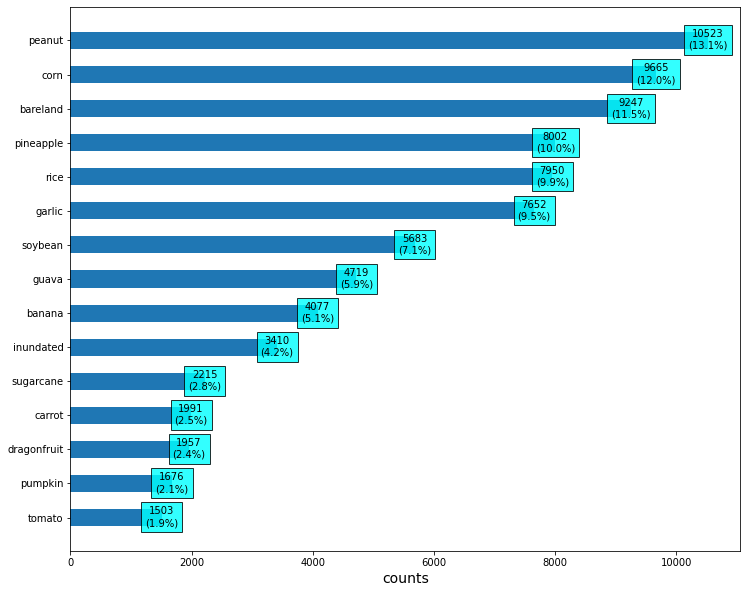

In [18]:
plt.figure(figsize=(12, 10))
# set data to plt.
plt.barh(group_by_label['true_label'].tolist(),
    group_by_label['counts'].tolist(), 
    height=0.5, 
    align='center')
# add label text to plt.
for i in range(len(group_by_label['true_label'])):
    counts = group_by_label['counts'].tolist()[i]
    proportion = counts/group_by_label['counts'].sum()
    plt.text(counts, i-.25, # (x,y)
        f"{counts}\n({round(proportion*100, 1)}%)", # label
        ha = 'center', 
        bbox = dict(facecolor = 'cyan', alpha =0.8)
    )
# add x,y lable to plt.
plt.xlabel('counts', fontsize=14)
plt.show()

### View counts of hours


In [10]:
data = pd.read_csv('./data/describe(fullset).csv')
data['taken_month'] = pd.to_datetime(data['taken_datetime']).dt.month
data['taken_year'] = pd.to_datetime(data['taken_datetime']).dt.year
data['taken_hour'] = pd.to_datetime(data['taken_datetime']).dt.hour
group_by_hh = data.groupby(['taken_hour']).size().reset_index(name='counts')
group_by_hh = group_by_hh.sort_values(by=['taken_hour'], inplace=False)

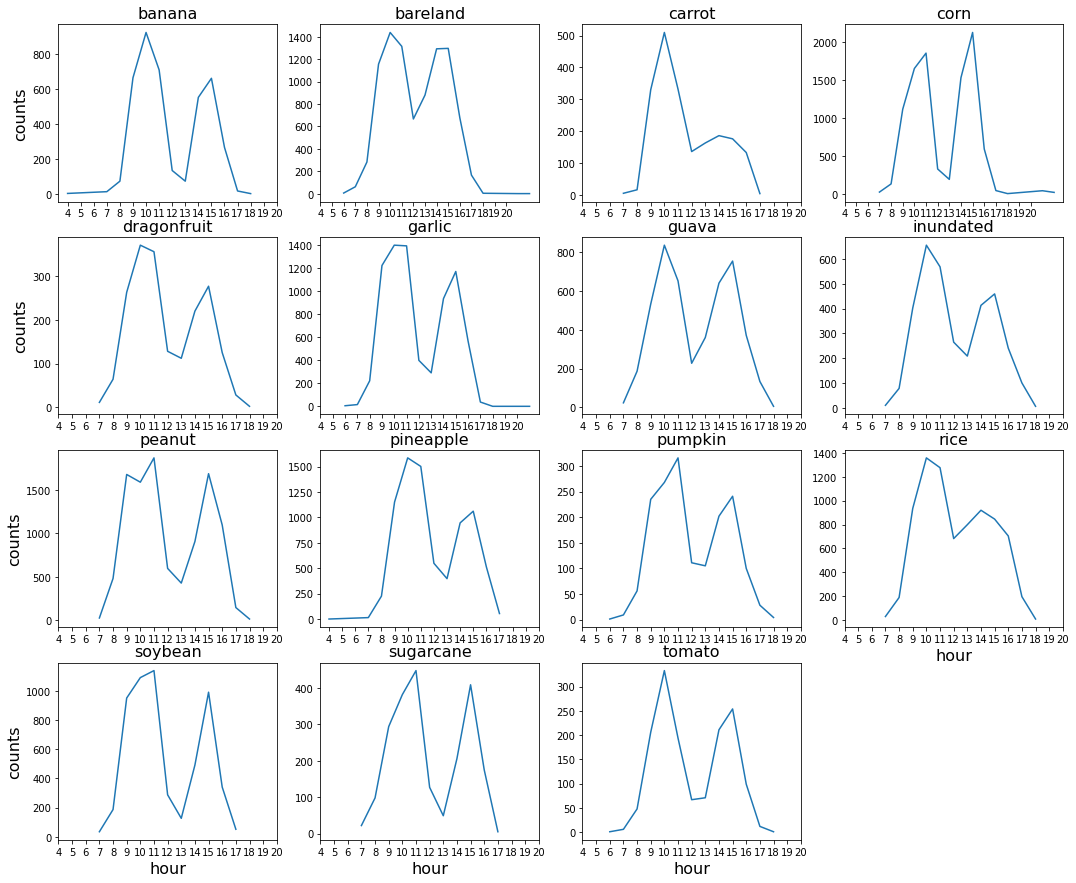

In [13]:
plt.figure(figsize=(18, 15))
for i, label in enumerate(labels):
    plt.subplot(4, 4, i+1)
    idf = data[data['true_label'].eq(label)]
    igroup = idf.groupby(['taken_hour']).size().reset_index(name='counts')
    igroup = igroup.sort_values(by=['taken_hour'], inplace=False)
    # plt.figure(figsize=(24, 6))
    plt.title(label, fontsize=16)
    plt.plot(igroup['taken_hour'], igroup['counts'], label='total')
    plt.xticks([*range(4,20+1)])
    if(i>10):
        plt.xlabel('hour', fontsize=16)
    if(i%(4)==0):
        plt.ylabel('counts', fontsize=16)
plt.show()



### View counts of years and months


In [ ]:
# - 2018 資料平均較少，推測測試資料可能是 2018 每月平均抽 50%，試試看只用 2018 年的資料訓練模型？
# - 1,2,3月(冬季)最多；4,5,10月(春季)次之；8,9,12月(秋季)偏少；6,7,11月(夏季)很少
# - 分析原始資料裡面，季節性、時間性是否平均分佈或集中在特定區段

In [14]:
group_by_yyyy = data.groupby(['taken_year']).size().reset_index(name='counts')
group_by_yyyy = group_by_yyyy.sort_values(by=['taken_year'], inplace=False)
group_by_mm = data.groupby(['taken_month']).size().reset_index(name='counts')
group_by_mm = group_by_mm.sort_values(by=['taken_month'], inplace=False)
group_by_yyyymm = data.groupby(['taken_year' ,'taken_month']).size().reset_index(name='counts')
group_by_yyyymm = group_by_yyyymm.sort_values(by=['taken_year', 'taken_month'], inplace=False)

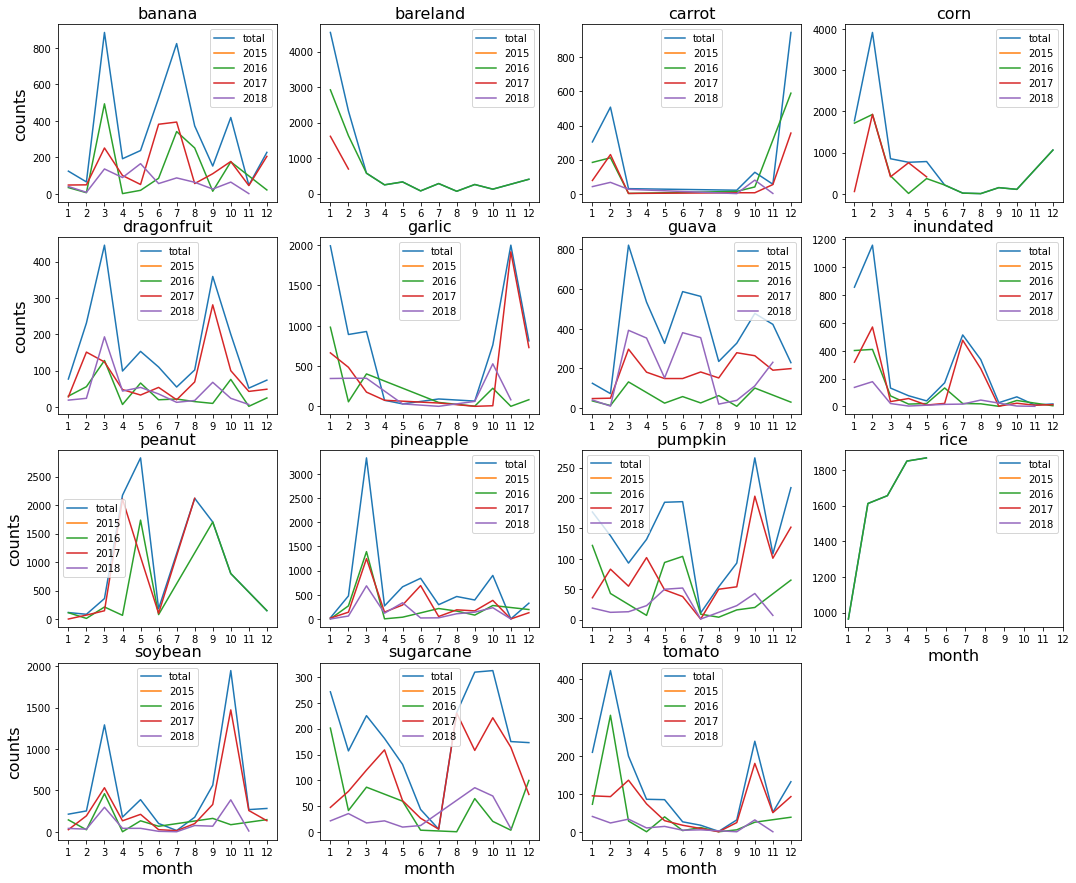

In [15]:
plt.figure(figsize=(18, 15))
# plt.suptitle(f'{plant_id}, Hourly radiation forecast error distribution', fontsize=18, y=0.92)
for i, label in enumerate(labels):
    plt.subplot(4, 4, i+1)
    idf = data[data['true_label'].eq(label)]
    igroup = idf.groupby(['taken_month']).size().reset_index(name='counts')
    igroup = igroup.sort_values(by=['taken_month'], inplace=False)
    # plt.figure(figsize=(24, 6))
    plt.title(label, fontsize=16)
    plt.plot(igroup['taken_month'], igroup['counts'], label='total')
    for yyyy in [2015,2016,2017,2018]:
        ijgroup = idf.groupby(['taken_year', 'taken_month']).size().reset_index(name='counts')
        ijgroup = ijgroup.sort_values(by=['taken_month'], inplace=False)
        ijgroup = ijgroup[ijgroup['taken_year'].eq(yyyy)]
        plt.plot(ijgroup['taken_month'], ijgroup['counts'], label=yyyy)
    plt.xticks([*range(1,12+1)])
    if(i>10):
        plt.xlabel('month', fontsize=16)
    if(i%(4)==0):
        plt.ylabel('counts', fontsize=16)
    plt.legend() 
plt.show()
